In [13]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from scipy.stats import iqr
from scipy.stats import norm 
from scipy.stats import lognorm 
import os

# Shutil is a recursive tool to delete file paths
# Note: Only needed if you plan to overwrite existing filepaths
import shutil

In [135]:
os.getcwd()

'C:\\Users\\admin\\Documents\\__SU22\\DOETrucksMeeting\\Scott\\OLS_6_28'

In [136]:
dataSourcePath = 'old_data\\Batch_Div27_2021_03_months_Conv_BE_RH_Base_Edges_Crr_Std_Results_metrics.xlsx'

In [137]:
# Load and trim Data
print('Loading Data...')
df = pd.read_excel(dataSourcePath, index_col=None, sheet_name = "DOE", \
                   usecols=['Vehicle Model-none',\
                      'Battery Energy Consumption per Mile-kWh/mi',\
                      'Vehicle Static Mass-lbm',\
#                           'Cycle Source-none',\
                      'Average Total Speed-mph',\
                      'Fuel Economy-mpg',\
                      'Cycle Name-none',\
                      'Cargo Mass-lbm'])
# Doing conversions
df['Fuel Economy-mpg'] = 1/(df['Fuel Economy-mpg']*1.60934)
df['Cargo Mass-lbm'] = df['Cargo Mass-lbm']*0.453592
df['Vehicle Static Mass-lbm'] = df['Vehicle Static Mass-lbm']*0.453592
df['Battery Energy Consumption per Mile-kWh/mi'] = df['Battery Energy Consumption per Mile-kWh/mi']/1.60934
df['Average Total Speed-mph'] = df['Average Total Speed-mph']*1.60934
df = df.rename(columns={'Fuel Economy-mpg': 'Fuel Economy-g/km', 'Cargo Mass-lbm' : 'Cargo Mass-kg',\
                        'Vehicle Static Mass-lbm' : 'Vehicle Static Mass-kg', \
                        'Battery Energy Consumption per Mile-kWh/mi' : 'Battery Energy Consumption per Mile-kWh/km',\
                        'Average Total Speed-mph' : 'Average Total Speed-km/h'
                       })

print('Done Loading Data!\n')

Loading Data...


KeyboardInterrupt: 

In [ ]:
df2 = df.copy()

print('Preprocessing Data...')
nodeOrder = pd.read_excel('old_data\\Batch_Div27_2021_03_months_Conv_BE_RH_Base_Edges_Crr_Std_Results_metrics.xlsx', \
                  sheet_name = "RouteMatching", \
                  index_col=None, usecols= ['Name3', 'Start Node Name', 'End Node Name', 'Start Node', 'End Node'])

def checking(x):
    for idx, y in enumerate(nodeOrder['Name3'].values):
        thres = 9
        y = y.replace('\'', '')
        a = x.split('_')[1:5]
        b = y.split('_')[1:5]

        a = [[int(j) for j in i.split('p')] for i in a]
        b = [[int(j) for j in i.split('p')] for i in b]

        # Check if the minutes are within +- thres 
        c = [((a[i][0] == b[i][0]) and (a[i][1] >= (b[i][1]-thres)) and (a[i][1] <= (b[i][1]+thres))) for i in range(np.size(a, 0))]

        # If all matches
        if (all(c)):
            # get the start, and end node
            i = nodeOrder['Start Node'].iloc[[idx]].values[0]
            j = nodeOrder['End Node'].iloc[[idx]].values[0]
            return (i, j)
    return np.nan

# Saving the sheet with the nodes labelled
temp = df.columns.get_loc('Cycle Name-none')
df2['temp'] = df2['Cycle Name-none'].apply(checking)
# df2 = df2[df2['temp'].notna()]
df2 = df2[~df2['temp'].isnull()]


a = pd.DataFrame(df2['temp'].tolist(), index=df2.index)
df2.insert(temp + 1, 'start_node', a[0])
df2.insert(temp + 2, 'end_node', a[1])
df2.drop('temp', inplace=True, axis=1)
df2.to_excel(dataSourcePath[:-5] + "_node_label.xlsx")
df2 = df2.rename(columns={'start_node': 'i', 'end_node' : 'j'})

# Return the total number of nodes here
numNodes = max(df2['i'].unique().max(), df2['j'].unique().max())
print('Labelled version of the sheet saved as: ', dataSourcePath[:-5] + "_node_label.xlsx")

# Function: generateData
### Performs OLS on every edge and saves a, b into csv and pickle files 

> (bool) freight : Freight mode calculation on or off  
(str) dataSourcePath : Source data file path (.xlsx)  
(str) saveFolderName : Name of the folder to save the data (non-existing)

## Note:  -1 is a dummy value (for self-loops and array padding)

In [53]:
def generateData (dataSourcePath = 'Batch_Div27_2021_03_months_Conv_BE_RH_Base_Edges_Crr_Std_Results_metrics.xlsx', \
                  freight = False,\
                  preprocessing = True,\
                  saveFiles= True,\
                  saveFolderName = "OLS_Data",\
                 ):
    parent_dir = os.getcwd()
    savePath = os.path.join(parent_dir, saveFolderName)
    
    # If the old date folder already exists, remove the folder
    print('Checking for prexisting data')
    if os.path.exists(savePath):
        shutil.rmtree(savePath)
        print('Removed ', savePath)

    if os.path.exists(dataSourcePath[:-5] + "_node_label.xlsx"):
        os.remove(dataSourcePath[:-5] + "_node_label.xlsx")
        print('Removed ', dataSourcePath[:-5] + "_node_label.xlsx")

    print('Removed all existing previous Data!\n')
    os.makedirs(savePath)
    
    # Load and trim Data
    print('Loading Data...')
    df = pd.read_excel(dataSourcePath, index_col=None, \
#                        sheet_name = "DOE", \
                       usecols=['Vehicle Model-none',\
                          'Battery Energy Consumption per Mile-kWh/mi',\
                          'Vehicle Static Mass-lbm',\
#                           'Cycle Source-none',\
                          'Average Total Speed-mph',\
                          'Fuel Economy-mpg',\
                          'Cycle Name-none',\
                          'Cargo Mass-lbm'])
    
    # #2 Diesel constant
    jpg   = 146520000
    jpkwh = 3600000
    
    # Doing conversions
    df['Fuel Economy-mpg'] = 1/(df['Fuel Economy-mpg']*1.60934) * jpg/100000
    df['Cargo Mass-lbm'] = df['Cargo Mass-lbm']*0.453592
    df['Vehicle Static Mass-lbm'] = df['Vehicle Static Mass-lbm']*0.453592
    df['Battery Energy Consumption per Mile-kWh/mi'] = (df['Battery Energy Consumption per Mile-kWh/mi']/1.60934)*jpkwh/100000
    df['Average Total Speed-mph'] = df['Average Total Speed-mph']*1.60934
    df = df.rename(columns={'Fuel Economy-mpg': 'Fuel Economy-MJ/km', 'Cargo Mass-lbm' : 'Cargo Mass-kg',\
                            'Vehicle Static Mass-lbm' : 'Vehicle Static Mass-kg', \
                            'Battery Energy Consumption per Mile-kWh/mi' : 'Battery Energy Consumption-MJ/km',\
                            'Average Total Speed-mph' : 'Average Total Speed-km/h'
                           })
    df.fillna(0, inplace=True)
    df.replace([np.inf, -np.inf], 0, inplace=True)
    
    print('Done Loading Data!\n')
    
    if preprocessing == True:
        print('Preprocessing Data...')
#         nodeOrder = pd.read_excel('0623_hetero\\Batch_Div27_2021_03_months_Conv_BE_RH_Base_Edges_Crr_Std_Results_metrics (1).xlsx', \
#                           sheet_name = "RouteMatching", \
#                           index_col=None, usecols= ['Name3', 'Start Node Name', 'End Node Name', 'Start Node', 'End Node'])
        nodeOrder = pd.read_excel('old_data\\Batch_Div27_2021_03_months_Conv_BE_RH_Base_Edges_Crr_Std_Results_metrics.xlsx', \
                          sheet_name = "RouteMatching", \
                          index_col=None, usecols= ['Name3', 'Start Node Name', 'End Node Name', 'Start Node', 'End Node'])

        def checking(x):
            for idx, y in enumerate(nodeOrder['Name3'].values):
                thres = 5
                y = y.replace('\'', '')
                a = x.split('_')[1:5]
                b = y.split('_')[1:5]

                a = [[int(j) for j in i.split('p')] for i in a]
                b = [[int(j) for j in i.split('p')] for i in b]

                # Check if the minutes are within +- 2 
                c = [((a[i][0] == b[i][0]) and (a[i][1] >= (b[i][1]-thres)) and (a[i][1] <= (b[i][1]+thres))) for i in range(np.size(a, 0))]

                # If all matches
                if (all(c)):
                    # get the start, and end node
                    i = nodeOrder['Start Node'].iloc[[idx]].values[0]
                    j = nodeOrder['End Node'].iloc[[idx]].values[0]
                    return (i, j)
            return np.nan
        
        # Saving the sheet with the nodes labelled
        temp = df.columns.get_loc('Cycle Name-none')
        df['temp'] = df['Cycle Name-none'].apply(checking)
        df = df[~df['temp'].isnull()]

        a = pd.DataFrame(df['temp'].tolist(), index=df.index)
        df.insert(temp + 1, 'start_node', a[0])
        df.insert(temp + 2, 'end_node', a[1])
        df.drop('temp', inplace=True, axis=1)
        df.to_excel(dataSourcePath[:-5] + "_node_label.xlsx")
        df = df.rename(columns={'start_node': 'i', 'end_node' : 'j'})

        # Return the total number of nodes here
        numNodes = max(df['i'].unique().max(), df['j'].unique().max())
        print('Labelled version of the sheet saved as: ', dataSourcePath[:-5] + "_node_label.xlsx")

    else:

        # Function to look for the number of nodes from a list of strings in the source file
        def findNumNodes(sentence_arr):
            running_max = 1
            length = len(sentence_arr)
            i_val = np.full(length, 0)
            j_val = np.full(length, 0)
            for index, sentence in enumerate(sentence_arr):

                # Split the string, and get the corresponding node values
                temp = sentence.lower().split('div')[1].split('_raw')[0].split('_')
                j = temp[-1]
                i = temp[-2]
                j = int(''.join([x for x in j if x.isdigit()]))
                i = int(''.join([x for x in i if x.isdigit()]))
                running_max = max(i, j, running_max)
                i_val[index], j_val[index] = i, j
            return running_max, i_val, j_val

        # Adding "i" and "j" columns for lookup convenience later in code
        numNodes, i_val, j_val = findNumNodes(df["Cycle Name-none"].values)
        df.drop("Cycle Name-none", axis = 'columns')
        df['i'], df['j'] = i_val, j_val
    
    print('Done Preprocessing Data!\n')
    
    # Setup for csv files index and column labels
    cols = ["i_" + str(i) for i in range(1, numNodes+1)]
    rows = ["j_" + str(i) for i in range(1, numNodes+1)]
    
    # Getting information from the dataframe
    vehicleTypes = pd.Series(df['Vehicle Model-none'].values).unique()
                   
    # Loop for Vehicle Types (k)
    for v in vehicleTypes:
        # check if the vehicle is conv or bev
        conv = (v.find('conv') != -1)
        erev = (v.find('erev') != -1)
        fchev = (v.find('fchev') != -1)
        mild = (v.find('mild') != -1)
        bev = (v.find('bev') != -1)
        
        b_list = np.array([])
        a_list = np.array([])
        workFrame = df[df["Vehicle Model-none"] == v]
        newFrame = pd.DataFrame(columns = cols, index = rows)
        print('\nFor Vehicle: ', v)

        
        if freight == True:
            x_val = 'Cargo Mass-kg'
        else:
            x_val = 'Vehicle Static Mass-kg'    
        if conv or fchev or mild:
            y_val = ['Fuel Economy-MJ/km']
            print('Detected type: conv, mild, or fchev')
        if erev:
            y_val = ['Fuel Economy-MJ/km', 'Battery Energy Consumption-MJ/km']
            print('Detected type: erev')
        else: # bev
            y_val = ['Battery Energy Consumption-MJ/km']
        
        print('LR Using:', '\nx_val = ', x_val, '\ny_val = ', y_val, '\n')
        
        # Iterate over node values i, j, and assign constants a, b, into "newFrame"
        for i in range(1, numNodes + 1):
            for j in range(1, numNodes + 1):
                data = workFrame.loc[((workFrame['i'] == i) & (workFrame['j'] == j))]
                
                # edge case if i = j or data Doesn't exist
                if i == j :
                    newFrame.iat[j - 1, i - 1] = -1
                    continue
                if data.size == 0:
                    newFrame.iat[j - 1, i - 1] = 0
                    continue

                # Doing linear regression here
                if len(y_val) > 1:
                    Y = (data.loc[:, [y_val[0]]].values + data.loc[:, [y_val[1]]].values).reshape(-1, 1)
                else:
                    Y = (data.loc[:, [y_val[0]]]).values.reshape(-1, 1)
                X = (data.loc[:, [x_val]]).values.reshape(-1, 1)
                LR = LinearRegression()  # create object for the class
                LR.fit(X, Y)  # perform linear regression
                
                x_label = x_val
                y_label = 'Energy Cost-J/km'
                Y_pred = LR.predict(X)  # make predictions

                # Data Visualization
#                 plt.figure()
#                 plt.scatter(X, Y)
#                 plt.plot(X, Y_pred, color='red', alpha = 0.3)
#                 plt.title('Battery energy cost VS '+ x_label + '\nfor vehiecle: ' + v)
#                 plt.xlabel(x_label)
#                 plt.ylabel(y_label)
                
                # Assigning the calculated a, b params
                newFrame.iat[j - 1, i - 1] = (LR.coef_.item(0), LR.intercept_.item(0))
                b = LR.intercept_.item(0)/ np.average(np.square(data.loc[:, ['Average Total Speed-km/h']]).values)
                a = LR.coef_.item(0)
#                 print("a =", a, ", b = ", b)
#                 print('Node: (', i, ',', j,'), Coeffs: a = ', LR.coef_.item(0), ', bv^2 = ', LR.intercept_.item(0),'b = ', b, ')', )
#                 break
                b_list = np.append(b_list, b)
                a_list = np.append(a_list, a)
#             break
                
        # Visualize histogram of the bs
        # Using the Freedman-Draconis Rule to determine bin size
        b_size = b_list.size
        percent_thres = 0.03 # take away 5%, 2 standard deiviatons
        cutoff = round(b_size*(percent_thres/2))
        b_list = np.sort(b_list)[:b_size-cutoff]
        print('# b-values: ', b_list.size)
        b_iqr = iqr(b_list, axis=None, rng=(25, 75), scale=1.0, nan_policy='propagate', interpolation='linear', keepdims=False)
        b_binsize = (2*b_iqr)/(b_size**(1/3))
        b_numBins = round((np.max(b_list) - np.min(b_list))/b_binsize)
        
        def mean_squared(n_normed, actual):
            actual_ = np.where(np.array(n_normed) == 0, 0, actual)
            return ((n_normed - actual_)**2).mean()
        plt.figure()
        n, bins, _ = plt.hist(b_list, bins = b_numBins, density = True)
        plt.title('Distribution of b_ijk')
        plt.xlabel('b_ijk')
        plt.ylabel('Density')

        centers_x = (0.5*(bins[1:]+bins[:-1]))
        params_logn = lognorm.fit(b_list)
        params_norm = norm.fit(b_list)
        xvals_calc = np.linspace(centers_x[0], centers_x[-1], centers_x.size)
        xvals_vis = np.linspace(bins[0]-(bins[1]-bins[0])*5 , bins[-1])
        pdf_logn_calc = lambda x: lognorm.pdf(xvals_calc, *params_logn)
        pdf_logn_vis = lambda x: lognorm.pdf(xvals_vis, *params_logn)
        pdf_norm_vis = lambda x: norm.pdf(xvals_vis, *params_norm)
        pdf_norm_calc = lambda x: lognorm.pdf(xvals_calc, *params_norm)

        ###Plotting the lognormal and normal fitting lines
        yvals_logn = pdf_logn_vis(xvals_vis)
        yvals_norm = pdf_norm_vis(xvals_vis)
        plt.plot(xvals_vis, yvals_logn)
        plt.plot(xvals_vis, yvals_norm)
        plt.show() 
        ### MSE Error Calculation
        yvals_logn = pdf_logn_calc(xvals_calc)
        yvals_norm = pdf_norm_calc(xvals_calc)
        print('Mean-Squared Error for lognorm fit: ', mean_squared(n, yvals_logn))
        print('Mean-Squared Error for Normal  fit: ', mean_squared(n, yvals_norm))

#       # testing using seaborn plot
#         sns.distplot(b_list, bins = b_numBins, fit=stats.lognorm) # normal distribution
#         plt.figure()

        a_size = a_list.size
#         cutoff = round(a_size*(percent_thres/2))
#         a_list = a_list[cutoff:a_size-cutoff]
        print('# a-values: ', a_list.size)
        a_iqr = iqr(a_list, axis=None, rng=(25, 75), scale=1.0, nan_policy='propagate', interpolation='linear', keepdims=False)
        a_binsize = (2*a_iqr)/(a_size**(1/3))
        a_numBins = round((np.max(a_list) - np.min(a_list))/a_binsize)

        plt.figure()
        n, bins, _ = plt.hist(a_list, bins = a_numBins, density = True)
        plt.title('Distribution of a_ijk')
        plt.xlabel('a_ijk')
        plt.ylabel('Density')

        centers_x = (0.5*(bins[1:]+bins[:-1]))
        params_logn = lognorm.fit(a_list)
        params_norm = norm.fit(a_list)
        xvals_calc = np.linspace(centers_x[0], centers_x[-1], centers_x.size)
        xvals_vis = np.linspace(bins[0]-(bins[1]-bins[0])*5 , bins[-1])
        pdf_logn_calc = lambda x: lognorm.pdf(xvals_calc, *params_logn)
        pdf_logn_vis = lambda x: lognorm.pdf(xvals_vis, *params_logn)
        pdf_norm_vis = lambda x: norm.pdf(xvals_vis, *params_norm)
        pdf_norm_calc = lambda x: lognorm.pdf(xvals_calc, *params_norm)

        ###Plotting the lognormal and normal fitting lines
        yvals_logn = pdf_logn_vis(xvals_vis)
        yvals_norm = pdf_norm_vis(xvals_vis)
        plt.plot(xvals_vis, yvals_logn)
        plt.plot(xvals_vis, yvals_norm)
        plt.show() 
        ### MSE Error Calculation
        yvals_logn = pdf_logn_calc(xvals_calc)
        yvals_norm = pdf_norm_calc(xvals_calc)
        print('Mean-Squared Error for lognorm fit: ', mean_squared(n, yvals_logn))
        print('Mean-Squared Error for Normal  fit: ', mean_squared(n, yvals_norm))
        
        
#       KDE Plotting
#         plt.figure()
#         s_b = pd.Series(b_list)
#         s_b.plot.kde()
#         plt.figure()
#         s_a = pd.Series(a_list)
#         s_a.plot.kde()
    
        # Create the filePath
        tempPath2 = os.path.join(savePath, v + ".csv")
        tempPath3 = os.path.join(savePath, v + ".pkl")
        newFrame.to_csv(tempPath2)
        newFrame.to_pickle(tempPath3)
#         break
#     break

Checking for prexisting data
Removed  C:\Users\admin\Documents\__SU22\DOETrucksMeeting\Scott\OLS_6_28\OLS_Data
Removed  0623_hetero\Batch_Div27_Rep_Day_Class_8_Compiled_Results_metrics_node_label.xlsx
Removed all existing previous Data!

Loading Data...
Done Loading Data!

Preprocessing Data...
Labelled version of the sheet saved as:  0623_hetero\Batch_Div27_Rep_Day_Class_8_Compiled_Results_metrics_node_label.xlsx
Done Preprocessing Data!


For Vehicle:  class8_conv_2021_low_sleeper_longhaul_FU19
Detected type: conv, mild, or fchev
LR Using: 
x_val =  Vehicle Static Mass-kg 
y_val =  ['Battery Energy Consumption-MJ/km'] 

# b-values:  33


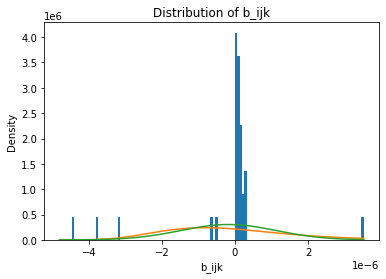

Mean-Squared Error for lognorm fit:  280650690257.0934
Mean-Squared Error for Normal  fit:  nan
# a-values:  34


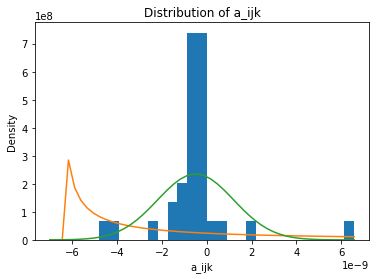

Mean-Squared Error for lognorm fit:  4.110455519046901e+16
Mean-Squared Error for Normal  fit:  nan

For Vehicle:  class8_mild48v_2021_low_sleeper_longhaul_FU19
Detected type: conv, mild, or fchev
LR Using: 
x_val =  Vehicle Static Mass-kg 
y_val =  ['Battery Energy Consumption-MJ/km'] 

# b-values:  33


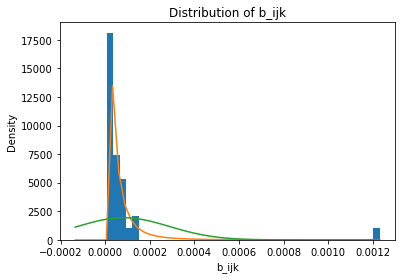

Mean-Squared Error for lognorm fit:  135267.9022521183
Mean-Squared Error for Normal  fit:  9738254.584143851
# a-values:  34


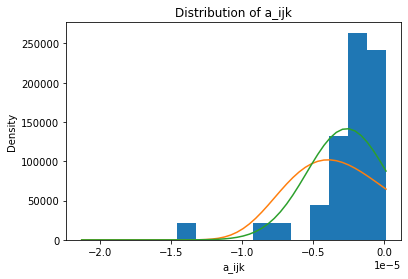

Mean-Squared Error for lognorm fit:  5938597697.794015
Mean-Squared Error for Normal  fit:  nan

For Vehicle:  class8_erev_2021_low_sleeper_longhaul_FU19
Detected type: erev
LR Using: 
x_val =  Vehicle Static Mass-kg 
y_val =  ['Fuel Economy-MJ/km', 'Battery Energy Consumption-MJ/km'] 

# b-values:  33


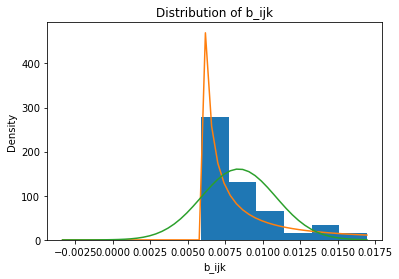

Mean-Squared Error for lognorm fit:  1689.5217705351513
Mean-Squared Error for Normal  fit:  16869.83199917244
# a-values:  34


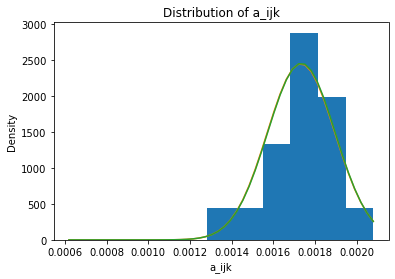

Mean-Squared Error for lognorm fit:  138841.7904464505
Mean-Squared Error for Normal  fit:  2440513.8203732152

For Vehicle:  class8_bev_2021_low_sleeper_longhaul_FU19
LR Using: 
x_val =  Vehicle Static Mass-kg 
y_val =  ['Battery Energy Consumption-MJ/km'] 

# b-values:  33


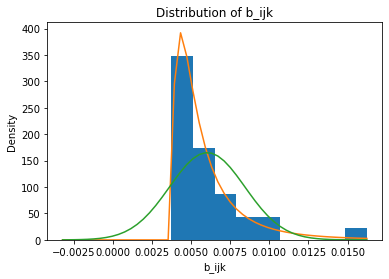

Mean-Squared Error for lognorm fit:  265.007815086308
Mean-Squared Error for Normal  fit:  18179.826916828097
# a-values:  34


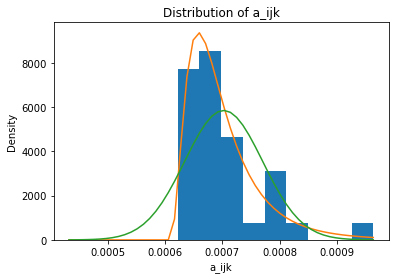

Mean-Squared Error for lognorm fit:  753982.4749739957
Mean-Squared Error for Normal  fit:  18366081.652276006

For Vehicle:  class8_fchev_2021_low_sleeper_longhaul_FU19
Detected type: conv, mild, or fchev
LR Using: 
x_val =  Vehicle Static Mass-kg 
y_val =  ['Battery Energy Consumption-MJ/km'] 

# b-values:  33


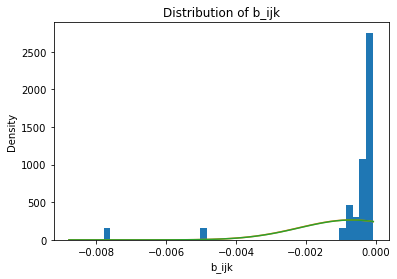

Mean-Squared Error for lognorm fit:  180193.41252625384
Mean-Squared Error for Normal  fit:  nan
# a-values:  34


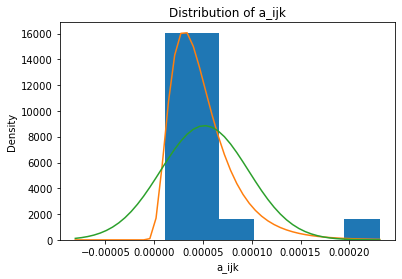

Mean-Squared Error for lognorm fit:  5273288.1773506915
Mean-Squared Error for Normal  fit:  65125022.67634251

For Vehicle:  class8_conv_2021_daycab_regionalhaul_FU19
Detected type: conv, mild, or fchev
LR Using: 
x_val =  Vehicle Static Mass-kg 
y_val =  ['Battery Energy Consumption-MJ/km'] 

# b-values:  33


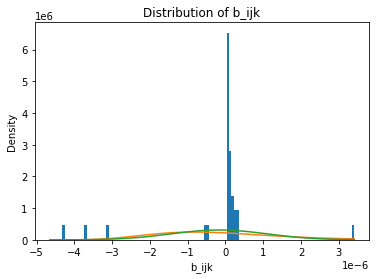

Mean-Squared Error for lognorm fit:  419730229220.50415
Mean-Squared Error for Normal  fit:  nan
# a-values:  34


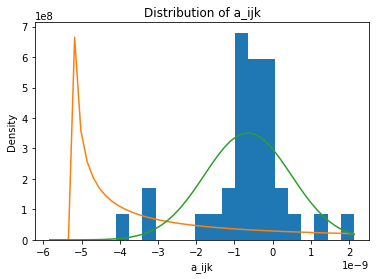

Mean-Squared Error for lognorm fit:  6.186446920658685e+16
Mean-Squared Error for Normal  fit:  nan

For Vehicle:  class8_mild48v_2021_daycab_regionalhaul_FU19
Detected type: conv, mild, or fchev
LR Using: 
x_val =  Vehicle Static Mass-kg 
y_val =  ['Battery Energy Consumption-MJ/km'] 

# b-values:  33


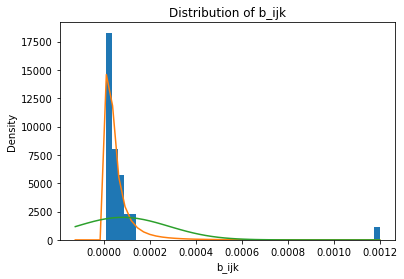

Mean-Squared Error for lognorm fit:  103604.91228730281
Mean-Squared Error for Normal  fit:  9840945.758432057
# a-values:  34


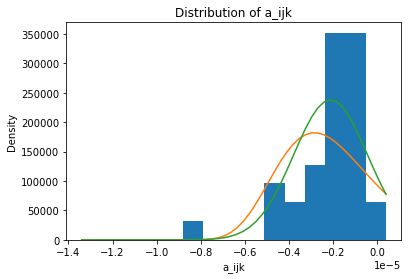

Mean-Squared Error for lognorm fit:  9810712668.40786
Mean-Squared Error for Normal  fit:  nan

For Vehicle:  class8_erev_2021_daycab_regionalhaul_FU19
Detected type: erev
LR Using: 
x_val =  Vehicle Static Mass-kg 
y_val =  ['Fuel Economy-MJ/km', 'Battery Energy Consumption-MJ/km'] 

# b-values:  33


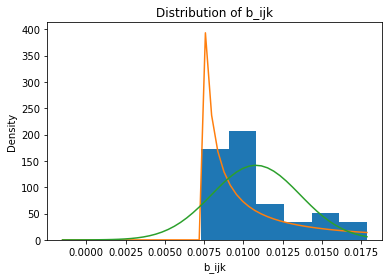

Mean-Squared Error for lognorm fit:  3369.5467651984013
Mean-Squared Error for Normal  fit:  13643.95110993484
# a-values:  34


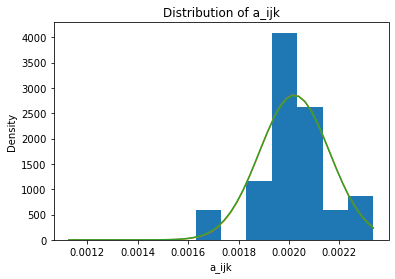

Mean-Squared Error for lognorm fit:  460234.7358314103
Mean-Squared Error for Normal  fit:  3782352.353081376

For Vehicle:  class8_bev_2021_daycab_regionalhaul_FU19
LR Using: 
x_val =  Vehicle Static Mass-kg 
y_val =  ['Battery Energy Consumption-MJ/km'] 

# b-values:  33


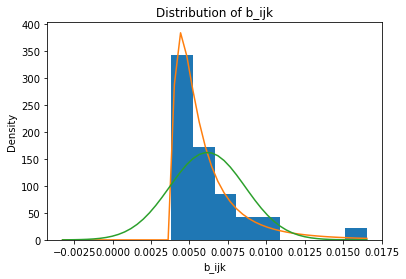

Mean-Squared Error for lognorm fit:  244.86244797667774
Mean-Squared Error for Normal  fit:  17596.89540554384
# a-values:  34


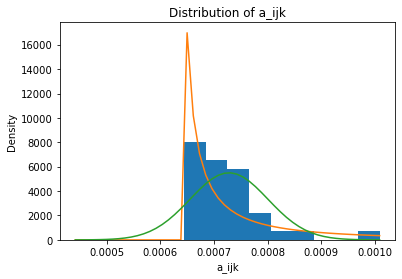

Mean-Squared Error for lognorm fit:  2783119.975901309
Mean-Squared Error for Normal  fit:  16294534.832015583

For Vehicle:  class8_fchev_2021_daycab_regionalhaul_FU19
Detected type: conv, mild, or fchev
LR Using: 
x_val =  Vehicle Static Mass-kg 
y_val =  ['Battery Energy Consumption-MJ/km'] 

# b-values:  33


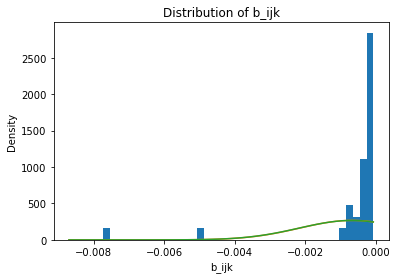

Mean-Squared Error for lognorm fit:  188202.76717412175
Mean-Squared Error for Normal  fit:  nan
# a-values:  34


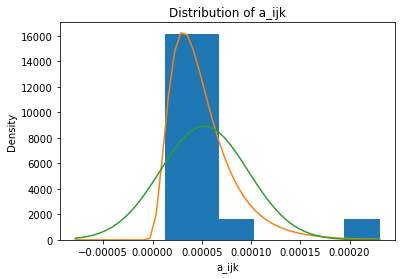

Mean-Squared Error for lognorm fit:  5412703.173323391
Mean-Squared Error for Normal  fit:  66350291.96849295


In [54]:
%matplotlib inline
dataSourcePath = '0623_hetero\\Batch_Div27_Rep_Day_Class_8_Compiled_Results_metrics.xlsx'
# dataSourcePath = 'old_data\\Batch_Div27_Class8_bev_1_Results_metrics.xlsx'
generateData(dataSourcePath, saveFolderName = "OLS_Data", preprocessing = True)

# Function: readData
 ### Reads the source folder generated by the  "generateData" function returns a, b, as dictionaries.
> Input:  
(str) saveFolderName: Name of source folder created by generateData
  
Output: 
>a [ k ][ i ][ j ]  
b [ k ][ i ][ j ] 


> (str) k : Vehiecle Type       
(int) i : i-node , index starts from 1  
(int) j : j-node , index starts from 1  

## Note:  -1 is a dummy value (for self-loops and array padding)

In [6]:
# Reads out the data and collects them into a dictionary.
def readDataCSV (saveFolderName = "OLS_Data"):
    
    # Initialize some folderpath
    path = os.path.join(os.getcwd(), saveFolderName)
    
    # If the folder doesn't exist, print error and return
    if not os.path.exists(path):
        print("Error, Source Folder Doesn't exist")
        return 
    VehiecleTypesPath = [ fi for fi in os.listdir(path) if fi.endswith(".pkl") ]
    VehiecleTypes = [i[:len(i) - 4] for i in VehiecleTypesPath] # change to use split or something else
    
    # Get the number of nodes brute forcedly
    filePath = os.path.join(path, VehiecleTypesPath[0])
    df = pd.read_pickle(filePath)
    numNodes = np.shape(df.iloc[:, 0].values)[0]
    
    # Initializing return dictionary
    a = {}
    b = {}

    for ind, v in enumerate(VehiecleTypes):
        filePath = os.path.join(path, v + ".pkl")
        df = pd.read_pickle(filePath)
        
        # initialize an empty array to store the days
        a[v] = np.full((numNodes + 1, numNodes + 1), -1, dtype = float)
        b[v] = np.full((numNodes + 1, numNodes + 1), -1, dtype = float)
        
        results = df.to_numpy().transpose()
        for i, temp in enumerate(results, 1):
            for j, ab in enumerate(temp, 1):
                if type(ab) == tuple:
                    a[v][i][j], b[v][i][j] = ab[0], ab[1] 
                else:
                    a[v][i][j], b[v][i][j] = ab, ab
                    
    return a, b

In [7]:
a, b = readDataCSV()

In [8]:
# Example lookup
k = 'class8_conv_2021_daycab_regionalhaul_FU19'
i = 73
j = 1

a[k][i][j], b[k][i][j] 

IndexError: index 73 is out of bounds for axis 0 with size 19

# 3D Plots

In [86]:
# Import libraries
## Basic libs
import pandas as pd
import numpy as np
import warnings
## Building Model
from sklearn import linear_model
from scipy import stats
import statsmodels
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.stats.api as sms
from statsmodels.compat import lzip
## Data Visualization
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib tk

# warnings.filterwarnings('ignore')
# plt.rcParams['figure.figsize'] = (7, 7)
# plt.style.use('ggplot')

In [87]:
def square(x):
    return x*x

################## Params #########################
dataSourcePath = '0623_hetero\\Batch_Div27_Rep_Day_Class_8_Compiled_Results_metrics.xlsx'
# dataSourcePath = 'old_data//Batch_Div27_2021_03_months_Conv_BE_RH_Base_Edges_Crr_Std_Results_metrics.xlsx'

In [88]:
# Loading Dataset
df_trucks = pd.read_excel(os.path.join(os.getcwd(), dataSourcePath), \
#                    sheet_name = "DOE",\
                   index_col=None, \
                   usecols=['Vehicle Model-none',\
                      'Fuel Consumption per 100 miles-Diesel Equiv. gal/100mi',\
                      'Battery Energy Consumption per Mile-kWh/mi',\
                      'Average Total Speed-mph',\
                      'Vehicle Static Mass-lbm']
                  )
# Data conversion
df_trucks['Vehicle Static Mass-lbm'] = df_trucks['Vehicle Static Mass-lbm']*0.453592
df_trucks.rename(columns = {'Vehicle Static Mass-lbm':'StaticMass-kg'}, inplace = True)
df_trucks['Average Total Speed-mph'] = (df_trucks['Average Total Speed-mph']*1.60934).apply(square)
df_trucks.rename(columns = {'Average Total Speed-mph':'SpeedSquared-(kmph)^2'}, inplace = True)

df_trucks['Fuel Consumption per 100 miles-Diesel Equiv. gal/100mi'] = df_trucks['Fuel Consumption per 100 miles-Diesel Equiv. gal/100mi']/160.934
df_trucks.rename(columns = {'Fuel Consumption per 100 miles-Diesel Equiv. gal/100mi':'FuelEconomy-gal/km'}, inplace = True)
df_trucks['Battery Energy Consumption per Mile-kWh/mi'] = df_trucks['Battery Energy Consumption per Mile-kWh/mi']/1.60934
df_trucks.rename(columns = {'Battery Energy Consumption per Mile-kWh/mi':'BatteryCost-kWh/km'}, inplace = True)

In [90]:
conv = df_trucks[df_trucks['Vehicle Model-none'] == 'class8_conv_2021_daycab_regionalhaul_FU19']
bev = df_trucks[df_trucks['Vehicle Model-none'] == 'class8_bev_2021_daycab_regionalhaul_FU19']

In [91]:
# Dropping unused columns
conv = conv.drop(['Vehicle Model-none', 'BatteryCost-kWh/km'], axis = 1)
bev = bev.drop(['Vehicle Model-none', 'FuelEconomy-gal/km'], axis = 1)

In [92]:
################## Params #########################
data = conv
energy = 'FuelEconomy-gal/km'
data

,StaticMass-kg,FuelEconomy-gal/km,SpeedSquared-(kmph)^2
3264,9071.840,0.052641,5370.721155
3265,9071.840,0.050246,5370.891963
3266,14514.944,0.059419,5371.401310
3267,14514.944,0.055612,5371.475417
3268,19958.048,0.066641,5369.802229
...,...,...,...
3667,25401.152,0.072676,6993.531902
3668,30844.256,0.086405,6964.883647
3669,30844.256,0.078554,6972.044299
3670,36287.360,0.093691,6927.716328


In [93]:
# Testing visualization
sns.set_palette('colorblind')
sns.pairplot(data=data, kind = 'reg', height=3, plot_kws = {'scatter_kws' : {'color': 'gray'}                                                     })

In [95]:
# Set independent and dependent variables
X = data[['StaticMass-kg', 'SpeedSquared-(kmph)^2']]
y = data[energy]

# Initialize model from sklearn and fit it into our data
regr = linear_model.LinearRegression()
model = regr.fit(X, y)
    
print('Intercept:', model.intercept_)
print('Coefficients:', model.coef_)

Intercept: 0.051685538978357676
Coefficients: [ 1.32104113e-06 -1.82180918e-06]


In [94]:
# # Values to predict
# vehicleMass = input('What is the Vehicle Mass? \n')
# avgSpeed = input('What is the average speed? \n')

# try:
#     print('We predict {:.0f} pies will be sold if we sold the pie at ${} and spend ${} at advertising.'.format(
#         model.predict([[float(vehicleMass), float(avgSpeed)]])[0],
#         vehicleMass, 
#         avgSpeed))
# except ValueError:
#     print('Please only input either:\n- whole number e.g. 1, 4, 7\n- decimal/float number e.g. 3.8')


In [96]:
# Prepare data
X = data[['StaticMass-kg', 'SpeedSquared-(kmph)^2']].values.reshape(-1,2)
Y = data[energy]

# Create range for each dimension
x = X[:, 0]
y = X[:, 1]
z = Y

xx_pred = np.linspace(9000, 37000, 30)  # range of mass values
yy_pred = np.linspace(0, 9000, 30)  # range of speed values
xx_pred, yy_pred = np.meshgrid(xx_pred, yy_pred)
model_viz = np.array([xx_pred.flatten(), yy_pred.flatten()]).T

# Predict using model built on previous step
# ols = linear_model.LinearRegression()
# model = ols.fit(X, Y)
predicted = model.predict(model_viz)

# Evaluate model by using it's R^2 score 
r2 = model.score(X, Y)

# Plot model visualization
plt.style.use('fivethirtyeight')

# fig = plt.figure(figsize=(12, 4))
fig = plt.figure()
ax1 = fig.add_subplot(111, projection='3d')
ax1.set_xlabel('StaticMass-kg', fontsize=12)
ax1.set_ylabel('AvgSpeed^2-(km/h)^2', fontsize=12)
ax1.set_zlabel(energy, fontsize=12)
ax1.scatter(xx_pred.flatten(), yy_pred.flatten(), predicted, facecolor=(0,0,0,0), s=20, edgecolor='#70b3f0')
ax1.scatter(x, y, z, color='k', alpha=0.5)
fig.suptitle('class8_conv_2021_daycab_regionalhaul_FU19')

plt.show()
# ax1 = fig.add_subplot(131, projection='3d')
# ax2 = fig.add_subplot(132, projection='3d')
# ax3 = fig.add_subplot(133, projection='3d')
# axes = [ax1, ax2, ax3]

# for ax in axes:
#     ax.plot(x, y, z, color='k', zorder=15, linestyle='none', marker='o', alpha=0.5)
#     ax.scatter(xx_pred.flatten(), yy_pred.flatten(), predicted, facecolor=(0,0,0,0), s=20, edgecolor='#70b3f0')
#     ax.set_xlabel('VehicleStaticMass (kg)', fontsize=12)
#     ax.set_ylabel('AverageSpeed (kmph)', fontsize=12)
#     ax.set_zlabel('Fuel Per km (gal/km)', fontsize=12)
#     ax.locator_params(nbins=4, axis='x')
#     ax.locator_params(nbins=5, axis='x')

# ax1.view_init(elev=25, azim=-60)
# ax2.view_init(elev=15, azim=15)
# ax3.view_init(elev=25, azim=60)

# fig.suptitle('Multi-Linear Regression Model Visualization ($R^2 = %.2f$)' % r2, fontsize=15, color='k')

# fig.tight_layout()

In [97]:
# BEV
################## Params #########################
data = bev
energy = 'BatteryCost-kWh/km'
data

,StaticMass-kg,BatteryCost-kWh/km,SpeedSquared-(kmph)^2
5712,9071.840,0.883727,5389.053957
5713,9071.840,0.833758,5389.149818
5714,14514.944,0.996935,5396.725360
5715,14514.944,0.917050,5396.844176
5716,19958.048,1.114676,5403.184812
...,...,...,...
6115,25401.152,1.228590,7040.693661
6116,30844.256,1.493345,7046.320873
6117,30844.256,1.322952,7047.482010
6118,36287.360,1.617237,7048.981953


In [98]:
# Set independent and dependent variables
X = data[['StaticMass-kg', 'SpeedSquared-(kmph)^2']]
y = data[energy]

# Initialize model from sklearn and fit it into our data
regr = linear_model.LinearRegression()
model = regr.fit(X, y)
    
print('Intercept:', model.intercept_)
print('Coefficients:', model.coef_)

Intercept: 0.6267966494648453
Coefficients: [2.01870275e-05 1.73455320e-05]


In [99]:
# Prepare data
X = data[['StaticMass-kg', 'SpeedSquared-(kmph)^2']].values.reshape(-1,2)
Y = data[energy]

# Create range for each dimension
x = X[:, 0]
y = X[:, 1]
z = Y

xx_pred = np.linspace(9000, 37000, 30)  # range of mass values
yy_pred = np.linspace(0, 9000, 30)  # range of speed values
xx_pred, yy_pred = np.meshgrid(xx_pred, yy_pred)
model_viz = np.array([xx_pred.flatten(), yy_pred.flatten()]).T

# Predict using model built on previous step
# ols = linear_model.LinearRegression()
# model = ols.fit(X, Y)
predicted = model.predict(model_viz)

# Evaluate model by using it's R^2 score 
r2 = model.score(X, Y)

# Plot model visualization
plt.style.use('fivethirtyeight')

# fig = plt.figure(figsize=(12, 4))
fig = plt.figure()
ax1 = fig.add_subplot(111, projection='3d')
ax1.set_xlabel('StaticMass-kg', fontsize=12)
ax1.set_ylabel('AvgSpeed^2-(km/h)^2', fontsize=12)
ax1.set_zlabel(energy, fontsize=12)
ax1.scatter(xx_pred.flatten(), yy_pred.flatten(), predicted, facecolor=(0,0,0,0), s=20, edgecolor='#70b3f0')
ax1.scatter(x, y, z, color='k', alpha=0.5)
fig.suptitle('class8_bev_2021_daycab_regionalhaul_FU19')

plt.show()

# Histogram Binning based on Freedman–Diaconis rule

NameError: name 'x' is not defined

In [48]:

x = [1,2 ,34, 5,56,51, 23, 2, 24, 52, 32,4, 43,6, 2,45,35 ,25,73, 345, 1,42,34, 2,5 ,236,53,31]
stats.iqr(x, axis=None, rng=(25, 75), scale=1.0, nan_policy='propagate', interpolation='linear', keepdims=False)

41.75

In [49]:
8**(1/3)

2.0

In [52]:
np.array(x).size

28

In [57]:
round(1.234)

1

In [64]:
stats.gaussian_kde(x, bw_method=None, weights=None)

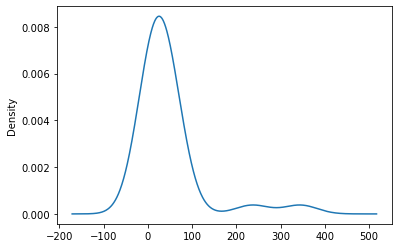

In [65]:
s = pd.Series(x)
ax = s.plot.kde()

In [73]:
sum = 0;
for i in range(25):
    sum += 2**(-i)
-sum

-1.9999999403953552

In [ ]:
1000 0001 1111 1111 1111 1111 11 .... 1100
0x8 1 F F F F F F

In [74]:
16**6 + 16**5 * 15+ 16**4 * 15+ 16**3 * 15

33550336

C:\Users\admin\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\admin\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

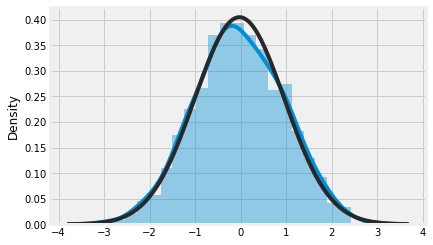

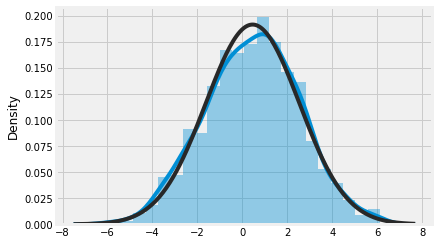

In [120]:
import seaborn as sns
import numpy as np
from scipy import stats

mu=0
sigma=1
n=1000

# x=np.random.normal(mu,sigma,n)
# sns.distplot(x, fit=stats.norm) # normal distribution

loc=0
scale=1

x=np.log(np.random.lognormal(loc,scale,n))
sns.distplot(x, fit=stats.lognorm) # log normal distribution